# **Segementation of Retinal Blood Vessels in Fundus Images using U-Net**

## Step 1: Import Libraries and Dataset

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, Model , Input
import tensorflow.image as tfi
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Dropout, concatenate, UpSampling2D
from keras.preprocessing.image import load_img, img_to_array
import os
import cv2
import matplotlib.pyplot as plt
from glob import glob
from keras.metrics import MeanIoU
from sklearn.model_selection import train_test_split

In [2]:
# Import retina dataset from Kaggle
import kagglehub
retina_dataset = kagglehub.dataset_download('abdallahwagih/retina-blood-vessel')

Using Colab cache for faster access to the 'retina-blood-vessel' dataset.


In [3]:
import os

base_path = retina_dataset  # this is the folder returned by kagglehub

train_images_path = os.path.join(base_path, 'Data/train/image')
train_masks_path  = os.path.join(base_path, 'Data/train/mask')
test_images_path  = os.path.join(base_path, 'Data/test/image')
test_masks_path   = os.path.join(base_path, 'Data/test/mask')

print("Base path:", base_path)
print("Train images path:", train_images_path)
print("Files found:", len(glob(os.path.join(train_images_path, '*.png'))))

Base path: /kaggle/input/retina-blood-vessel
Train images path: /kaggle/input/retina-blood-vessel/Data/train/image
Files found: 80


# Step 2: Load and Resize Images and Masks

In [4]:
def load_imgs(folder):
    imgs = []

    for file in glob(os.path.join(folder, '*.png')):
        img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        imgs.append(img)

    return imgs

def resize_imgs(imgs, size):
    resized_imgs = []

    for img in imgs:
        resized_img = cv2.resize(img, size)
        resized_imgs.append(resized_img)

    return np.array(resized_imgs)

In [5]:
train_images = load_imgs(train_images_path)
train_masks = load_imgs(train_masks_path)
test_images = load_imgs(test_images_path)
test_masks = load_imgs(test_masks_path)

In [6]:
# Resize images and masks to size 256
train_images = resize_imgs(train_images, (256, 256))
train_masks = resize_imgs(train_masks, (256, 256))
test_images = resize_imgs(test_images, (256, 256))
test_masks = resize_imgs(test_masks, (256, 256))

In [7]:
# Normalize images and masks
train_images = train_images / 255.0
train_masks = train_masks / 255.0
test_images = test_images / 255.0
test_masks = test_masks / 255.0

In [8]:
# Add a channel dimension to tensors for images and masks
train_images = tf.expand_dims(train_images, axis = -1)
train_masks = tf.expand_dims(train_masks, axis = -1)
test_images = tf.expand_dims(test_images, axis = -1)
test_masks = tf.expand_dims(test_masks, axis = -1)

In [9]:
print(f"Train Images Shape: {train_images.shape}")
print(f"Train Masks Shape: {train_masks.shape}")
print(f"Test Images Shape: {test_images.shape}")
print(f"Test Masks Shape: {test_masks.shape}")

Train Images Shape: (80, 256, 256, 1)
Train Masks Shape: (80, 256, 256, 1)
Test Images Shape: (20, 256, 256, 1)
Test Masks Shape: (20, 256, 256, 1)


# Step 3: Visualize Dataset (Images, Masks, Overlays)

In [57]:
def visualize_samples(images, masks, num_samples=5, title_prefix='Train'):
    fig, axes = plt.subplots(num_samples, 3, figsize=(8, 4 * num_samples))

    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_samples):
        idx = np.random.randint(len(images))

        img = np.squeeze(images[idx])
        msk = np.squeeze(masks[idx])

        # Original/preprocessed image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f'Image', fontweight='bold')
        axes[i, 0].axis('off')

        # Mask
        axes[i, 1].imshow(msk)
        axes[i, 1].set_title(f'Mask', fontweight='bold')
        axes[i, 1].axis('off')

        # Overlay
        axes[i, 2].imshow(img)
        axes[i, 2].imshow(msk, cmap='jet', alpha=0.5)
        axes[i, 2].set_title(f'Overlay', fontweight='bold')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

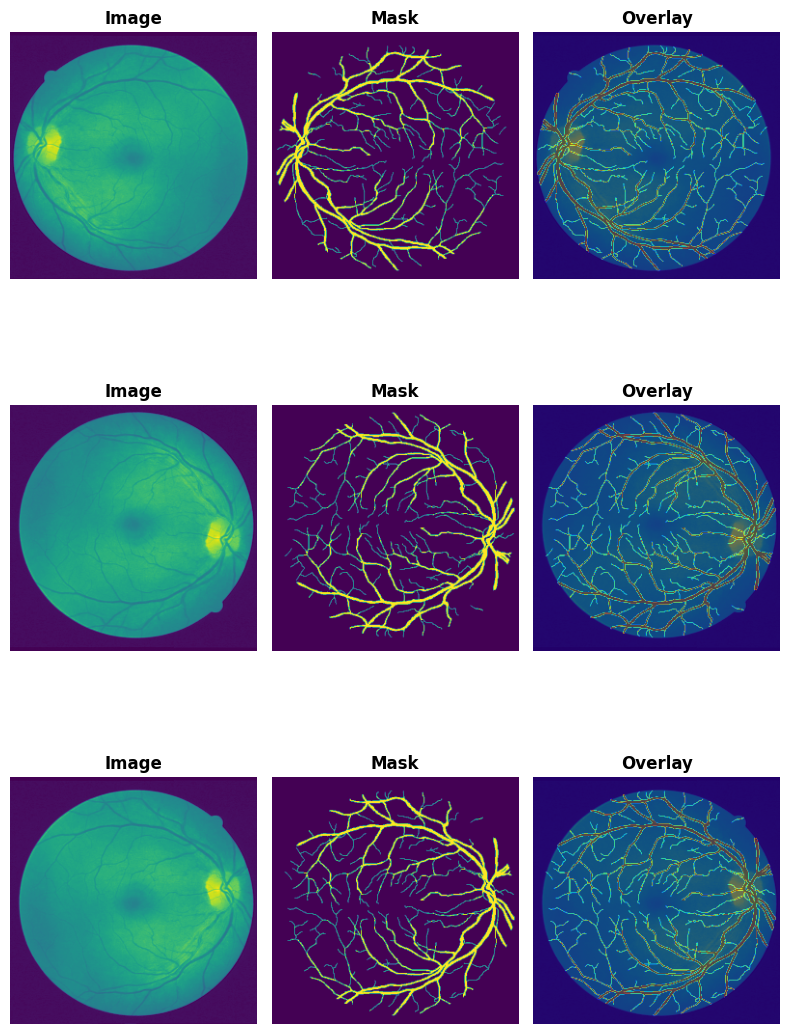

In [58]:
visualize_samples(train_images, train_masks, num_samples=3, title_prefix='Train')

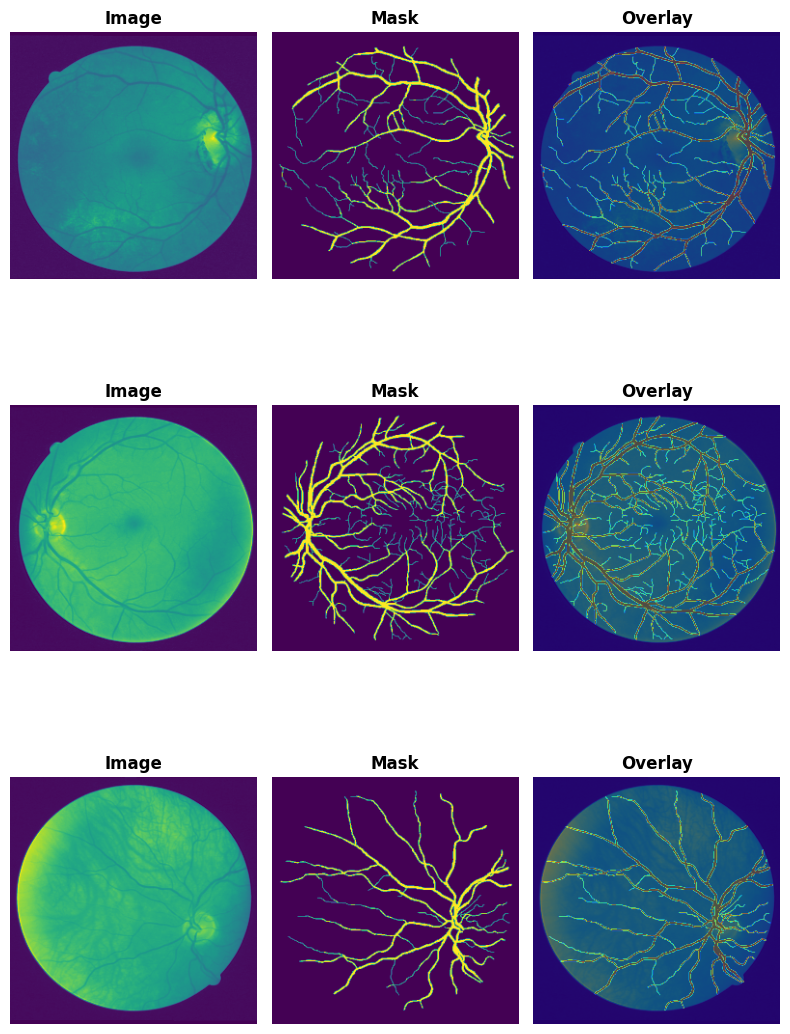

In [59]:
visualize_samples(train_images, train_masks, num_samples=3, title_prefix='Test')

# Step 4: Build U-Net Model

In [13]:
def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2D(512, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = Conv2D(256, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = Conv2D(64, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    # Output
    conv9 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv9)

    return model

In [14]:
model = unet_model(input_size=(256, 256, 1))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_9[0][0]  

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Function for IoU -> measures how much the predicted mask overlaps with the ground truth mask relative to their combined area
def IoU_measure(y_true, y_pred):
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])  # Flatten and cast ground truth (y_true) to float32
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])  # Flatten and cast predictions (y_pred) to float32
    intersection = tf.reduce_sum(y_true_f * y_pred_f)  # Compute intersection
    total = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection  # Total number of pixels
    return (intersection) / (total)

# Function for Dice coefficient -> measures overlap with emphasis on the size of the intersection relative to the total size of both masks
def dice_coeff_measure(y_true, y_pred):
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])  # Flatten and cast ground truth (y_true) to float32
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])  # Flatten and cast predictions (y_pred) to float32
    intersection = tf.reduce_sum(y_true_f * y_pred_f) # Compute intersection
    return (2. * intersection) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)) # Calculate the Dice coefficient using the formula

In [16]:
# Compile model
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics=['accuracy', dice_coeff_measure, IoU_measure])

# Step 5: Train U-Net Model

### A) Testing with Batch Size 8

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint

size = 256
batch = 8
num_epochs = 175

# Saving the model with the best validation dice coefficient during training
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_dice_coefficient',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False,
)

# Fit the model with multi-processing enabled
results1 = model.fit(
    train_images,
    train_masks,
    validation_data = (test_images,test_masks),
    batch_size=batch,
    epochs=num_epochs,
    callbacks=[checkpoint],
)

Epoch 1/175
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8407 - dice_coeff_measure: 0.1227 - io_u_measure: 0.0659 - loss: 7.3289

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_dice_coefficient available.
  if self._should_save_model(epoch, batch, logs, filepath):


10/10 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8406 - dice_coeff_measure: 0.1225 - io_u_measure: 0.0658 - loss: 7.2727 - val_accuracy: 0.8388 - val_dice_coeff_measure: 0.1294 - val_io_u_measure: 0.0692 - val_loss: 0.5345
Epoch 2/175
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - accuracy: 0.8377 - dice_coeff_measure: 0.0985 - io_u_measure: 0.0522 - loss: 0.4519 - val_accuracy: 0.8388 - val_dice_coeff_measure: 0.0652 - val_io_u_measure: 0.0337 - val_loss: 0.3361
Epoch 3/175
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 233ms/step - accuracy: 0.8404 - dice_coeff_measure: 0.0734 - io_u_measure: 0.0382 - loss: 0.3142 - val_accuracy: 0.8388 - val_dice_coeff_measure: 0.1408 - val_io_u_measure: 0.0757 - val_loss: 0.2655
Epoch 4/175
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step - accuracy: 0.8399 - dice_coeff_measure: 0.1364 - io_u_measure: 0.0732 - loss: 0.2659 - val_accuracy: 0.8388 - val_dice_coeff_measure: 0.1338 - val_io_u_measure: 0.0717 - val_loss: 0.2616
Epoch 5/175
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/st

In [18]:
print("Best training accuracy from batch size 8:", max(results1.history['accuracy']))
print("Best validation accuracy from batch size 8:", max(results1.history['val_accuracy']))
print("Best training Dice coefficient from batch size 8:", max(results1.history['dice_coeff_measure']))
print("Best validation Dice coefficient from batch size 8:", max(results1.history['val_dice_coeff_measure']))
print("Best training IoU from batch size 8:", max(results1.history['io_u_measure']))
print("Best validation IoU from batch size 8:", max(results1.history['val_io_u_measure']))

Best training accuracy from batch size 8: 0.8667501211166382
Best validation accuracy from batch size 8: 0.8666908144950867
Best training Dice coefficient from batch size 8: 0.6449226140975952
Best validation Dice coefficient from batch size 8: 0.6511613726615906
Best training IoU from batch size 8: 0.47603902220726013
Best validation IoU from batch size 8: 0.4827664792537689


### B) Testing with Batch Size 4

In [19]:
size = 256
batch = 4
num_epochs = 175

# Saving the model with the best validation dice coefficient during training
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_dice_coefficient',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False,
)

# Fit the model with multi-processing enabled
results2 = model.fit(
    train_images,
    train_masks,
    validation_data = (test_images,test_masks),
    batch_size=batch,
    epochs=num_epochs,
    callbacks=[checkpoint],
)

Epoch 1/175
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 117ms/step - accuracy: 0.8672 - dice_coeff_measure: 0.6472 - io_u_measure: 0.4786 - loss: 0.1066 - val_accuracy: 0.8665 - val_dice_coeff_measure: 0.6481 - val_io_u_measure: 0.4794 - val_loss: 0.1100
Epoch 2/175
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.8670 - dice_coeff_measure: 0.6371 - io_u_measure: 0.4677 - loss: 0.1103 - val_accuracy: 0.8665 - val_dice_coeff_measure: 0.6550 - val_io_u_measure: 0.4870 - val_loss: 0.1107
Epoch 3/175
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.8623 - dice_coeff_measure: 0.6382 - io_u_measure: 0.4688 - loss: 0.1123 - val_accuracy: 0.8666 - val_dice_coeff_measure: 0.6459 - val_io_u_measure: 0.4770 - val_loss: 0.1109
Epoch 4/175
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.8634 - dice_coeff_measure: 0.6380 - io_u_measure: 0.4685 - loss: 0.1131 - val_accuracy: 0.8666 - val_dice_coeff_measure: 0.6504 - val_io_u_measure: 0.4820 - val_loss: 0.1097
Epoch 5/175
20/20 ━━━━━━━━━━━━━━━━━

In [20]:
print("Best training accuracy from batch size 4:", max(results2.history['accuracy']))
print("Best validation accuracy from batch size 4:", max(results2.history['val_accuracy']))
print("Best training Dice coefficient from batch size 4:", max(results2.history['dice_coeff_measure']))
print("Best validation Dice coefficient from batch size 4:", max(results2.history['val_dice_coeff_measure']))
print("Best training IoU from batch size 4:", max(results2.history['io_u_measure']))
print("Best validation IoU from batch size 4:", max(results2.history['val_io_u_measure']))

Best training accuracy from batch size 4: 0.8684768676757812
Best validation accuracy from batch size 4: 0.8667991757392883
Best training Dice coefficient from batch size 4: 0.7294836044311523
Best validation Dice coefficient from batch size 4: 0.6809482574462891
Best training IoU from batch size 4: 0.5742419362068176
Best validation IoU from batch size 4: 0.5162638425827026


### C) Testing with Batch Size 2

In [21]:
size = 256
batch = 4
num_epochs = 175

# Saving the model with the best validation dice coefficient during training
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_dice_coefficient',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False,
)

# Fit the model with multi-processing enabled
results3 = model.fit(
    train_images,
    train_masks,
    validation_data = (test_images,test_masks),
    batch_size=batch,
    epochs=num_epochs,
    callbacks=[checkpoint],
)

Epoch 1/175
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.8707 - dice_coeff_measure: 0.7267 - io_u_measure: 0.5708 - loss: 0.0728 - val_accuracy: 0.8660 - val_dice_coeff_measure: 0.6691 - val_io_u_measure: 0.5028 - val_loss: 0.1344
Epoch 2/175
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.8696 - dice_coeff_measure: 0.7309 - io_u_measure: 0.5760 - loss: 0.0740 - val_accuracy: 0.8663 - val_dice_coeff_measure: 0.6765 - val_io_u_measure: 0.5111 - val_loss: 0.1426
Epoch 3/175
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.8637 - dice_coeff_measure: 0.7291 - io_u_measure: 0.5738 - loss: 0.0768 - val_accuracy: 0.8662 - val_dice_coeff_measure: 0.6760 - val_io_u_measure: 0.5106 - val_loss: 0.1405
Epoch 4/175
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.8700 - dice_coeff_measure: 0.7319 - io_u_measure: 0.5772 - loss: 0.0731 - val_accuracy: 0.8662 - val_dice_coeff_measure: 0.6768 - val_io_u_measure: 0.5115 - val_loss: 0.1392
Epoch 5/175
20/20 ━━━━━━━━━━━━━━━━━━

In [22]:
print("Best training accuracy from batch size 2:", max(results3.history['accuracy']))
print("Best validation accuracy from batch size 2:", max(results3.history['val_accuracy']))
print("Best training Dice coefficient from batch size 2:", max(results3.history['dice_coeff_measure']))
print("Best validation Dice coefficient from batch size 2:", max(results3.history['val_dice_coeff_measure']))
print("Best training IoU from batch size 2:", max(results3.history['io_u_measure']))
print("Best validation IoU from batch size 2:", max(results3.history['val_io_u_measure']))

Best training accuracy from batch size 2: 0.8685222864151001
Best validation accuracy from batch size 2: 0.8663299679756165
Best training Dice coefficient from batch size 2: 0.7497872710227966
Best validation Dice coefficient from batch size 2: 0.6867661476135254
Best training IoU from batch size 2: 0.5998066067695618
Best validation IoU from batch size 2: 0.5229806303977966


### D) Testing with Batch Size 1

In [23]:
size = 256
batch = 4
num_epochs = 175

# Saving the model with the best validation dice coefficient during training
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_dice_coefficient',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False,
)

# Fit the model with multi-processing enabled
results4 = model.fit(
    train_images,
    train_masks,
    validation_data = (test_images,test_masks),
    batch_size=batch,
    epochs=num_epochs,
    callbacks=[checkpoint],
)

Epoch 1/175
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.8693 - dice_coeff_measure: 0.7502 - io_u_measure: 0.6004 - loss: 0.0673 - val_accuracy: 0.8659 - val_dice_coeff_measure: 0.6852 - val_io_u_measure: 0.5211 - val_loss: 0.1614
Epoch 2/175
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.8685 - dice_coeff_measure: 0.7487 - io_u_measure: 0.5984 - loss: 0.0679 - val_accuracy: 0.8660 - val_dice_coeff_measure: 0.6817 - val_io_u_measure: 0.5171 - val_loss: 0.1640
Epoch 3/175
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.8663 - dice_coeff_measure: 0.7514 - io_u_measure: 0.6019 - loss: 0.0685 - val_accuracy: 0.8661 - val_dice_coeff_measure: 0.6830 - val_io_u_measure: 0.5186 - val_loss: 0.1650
Epoch 4/175
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.8707 - dice_coeff_measure: 0.7527 - io_u_measure: 0.6035 - loss: 0.0664 - val_accuracy: 0.8659 - val_dice_coeff_measure: 0.6836 - val_io_u_measure: 0.5193 - val_loss: 0.1628
Epoch 5/175
20/20 ━━━━━━━━━━━━━━━━━━

In [24]:
print("Best training accuracy from batch size 1:", max(results4.history['accuracy']))
print("Best validation accuracy from batch size 1:", max(results4.history['val_accuracy']))
print("Best training Dice coefficient from batch size 1:", max(results4.history['dice_coeff_measure']))
print("Best validation Dice coefficient from batch size 1:", max(results4.history['val_dice_coeff_measure']))
print("Best training IoU from batch size 1:", max(results4.history['io_u_measure']))
print("Best validation IoU from batch size 1:", max(results4.history['val_io_u_measure']))

Best training accuracy from batch size 1: 0.8685228228569031
Best validation accuracy from batch size 1: 0.8661842346191406
Best training Dice coefficient from batch size 1: 0.7571867108345032
Best validation Dice coefficient from batch size 1: 0.6904871463775635
Best training IoU from batch size 1: 0.6092982888221741
Best validation IoU from batch size 1: 0.5273063778877258


In [25]:
import pandas as pd

# histories for each batch size
hist_8 = results1.history    # batch_size = 8
hist_4 = results2.history    # batch_size = 4
hist_2 = results3.history    # batch_size = 2
hist_1 = results4.history    # batch_size = 1

batch_sizes = [8, 4, 2, 1]

best_train_acc = [
    max(hist_8['accuracy']),
    max(hist_4['accuracy']),
    max(hist_2['accuracy']),
    max(hist_1['accuracy'])
]

best_val_acc = [
    max(hist_8['val_accuracy']),
    max(hist_4['val_accuracy']),
    max(hist_2['val_accuracy']),
    max(hist_1['val_accuracy'])
]

best_train_dice = [
    max(hist_8['dice_coeff_measure']),
    max(hist_4['dice_coeff_measure']),
    max(hist_2['dice_coeff_measure']),
    max(hist_1['dice_coeff_measure'])
]

best_val_dice = [
    max(hist_8['val_dice_coeff_measure']),
    max(hist_4['val_dice_coeff_measure']),
    max(hist_2['val_dice_coeff_measure']),
    max(hist_1['val_dice_coeff_measure'])
]

best_train_iou = [
    max(hist_8['io_u_measure']),
    max(hist_4['io_u_measure']),
    max(hist_2['io_u_measure']),
    max(hist_1['io_u_measure'])
]

best_val_iou = [
    max(hist_8['val_io_u_measure']),
    max(hist_4['val_io_u_measure']),
    max(hist_2['val_io_u_measure']),
    max(hist_1['val_io_u_measure'])
]

lowest_loss = [
    min(hist_8['loss']),
    min(hist_4['loss']),
    max(hist_2['loss']),
    min(hist_1['loss'])
]

lowest_loss_val = [
    min(hist_8['val_loss']),
    min(hist_4['val_loss']),
    max(hist_2['val_loss']),
    min(hist_1['val_loss'])
]

metrics_df = pd.DataFrame({
    'Batch size': batch_sizes,
    'Best train accuracy': best_train_acc,
    'Best val accuracy': best_val_acc,
    'Best train Dice': best_train_dice,
    'Best val Dice': best_val_dice,
    'Best train IoU': best_train_iou,
    'Best val IoU': best_val_iou,
    'Lowest loss': lowest_loss,
    'Lowest val loss': lowest_loss_val
})

print(metrics_df)

   Batch size  Best train accuracy  Best val accuracy  Best train Dice  \
0           8             0.866750           0.866691         0.644923   
1           4             0.868477           0.866799         0.729484   
2           2             0.868522           0.866330         0.749787   
3           1             0.868523           0.866184         0.757187   

   Best val Dice  Best train IoU  Best val IoU  Lowest loss  Lowest val loss  
0       0.651161        0.476039      0.482766     0.106640         0.109669  
1       0.680948        0.574242      0.516264     0.074098         0.109035  
2       0.686766        0.599807      0.522981     0.074615         0.170406  
3       0.690487        0.609298      0.527306     0.065264         0.159721  


# Step 6: View Model Results

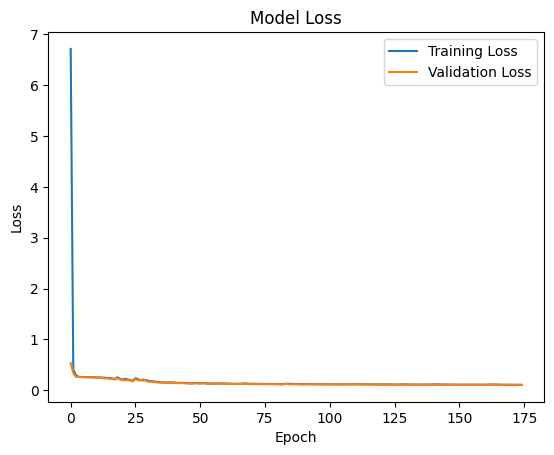

In [45]:
# Plot model loss per epoch
epochs = range(num_epochs)
train_loss = results1.history['loss']
val_loss = results1.history['val_loss']
train_acc = results1.history['accuracy']
val_acc = results1.history['val_accuracy']

plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend()
plt.show()

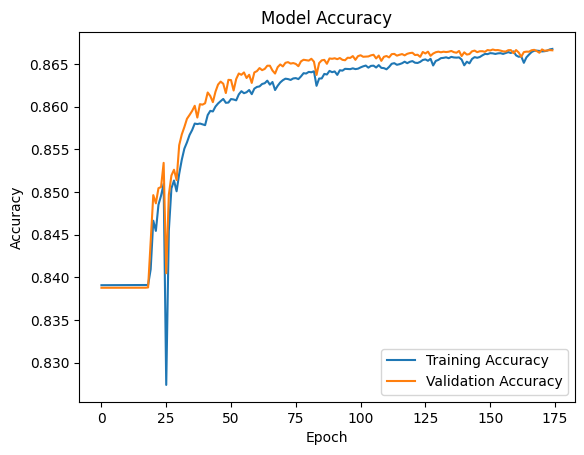

In [33]:
# Plot model accuracy per epoch
plt.plot(epochs, train_acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()
plt.show()

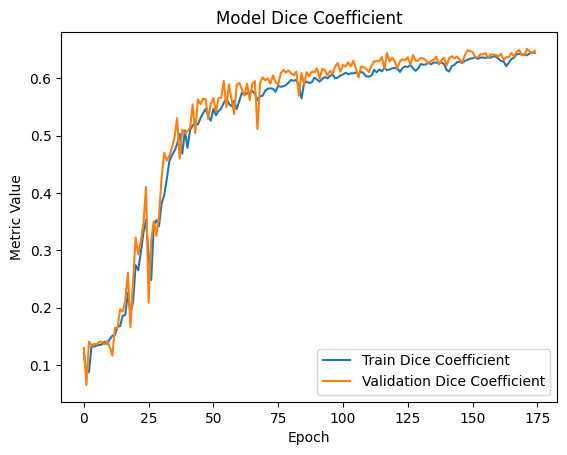

In [37]:
# Plot model Dice coefficient values
plt.plot(results1.history['dice_coeff_measure'], label='Train Dice Coefficient')
plt.plot(results1.history['val_dice_coeff_measure'], label='Validation Dice Coefficient')
plt.ylabel('Metric Value')
plt.xlabel('Epoch')
plt.title('Model Dice Coefficient')
plt.legend()
plt.show()

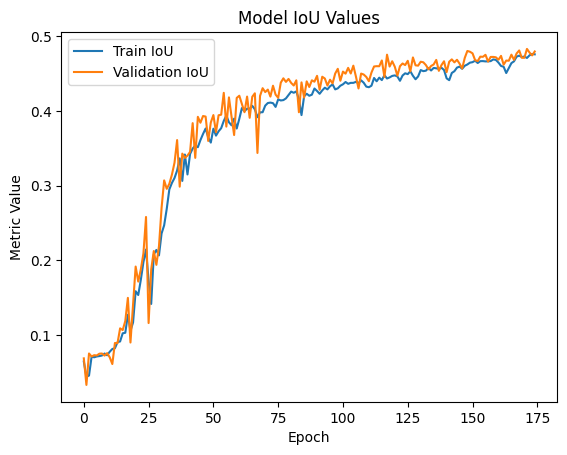

In [41]:
# Plot model IoU values
plt.plot(results1.history['io_u_measure'], label='Train IoU')
plt.plot(results1.history['val_io_u_measure'], label='Validation IoU')
plt.ylabel('Metric Value')
plt.xlabel('Epoch')
plt.title('Model IoU Values')
plt.legend()
plt.show()

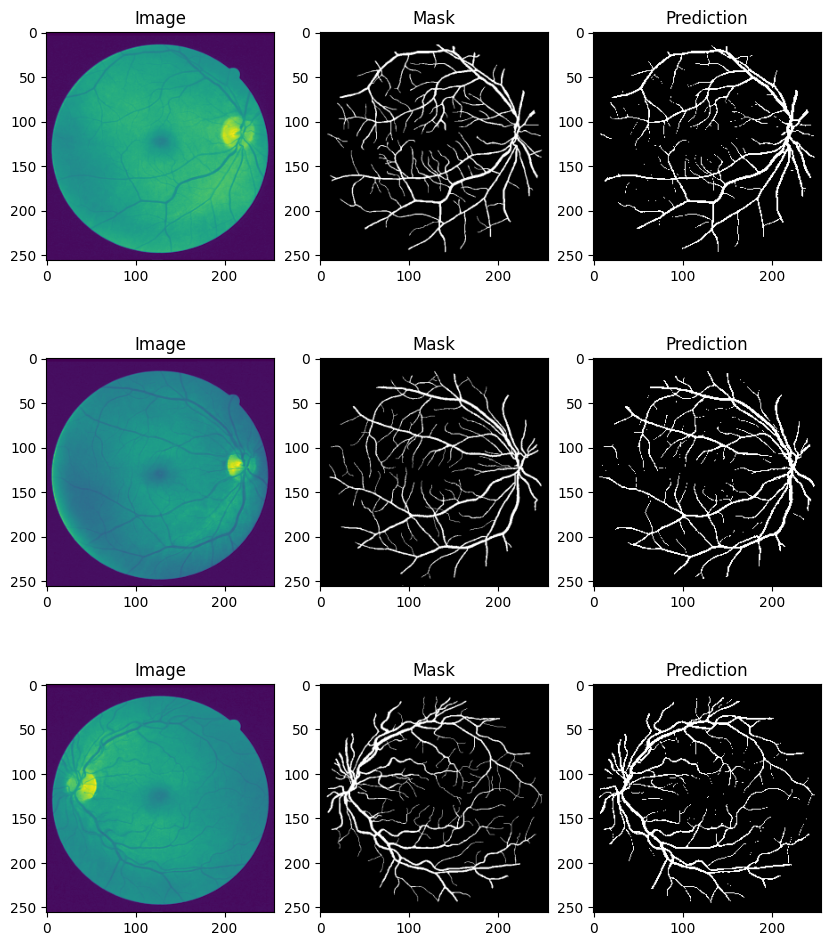

In [50]:
# Validate predicted results with expected
fig, ax = plt.subplots(3,3, figsize=(10,12))
test_images,test_masks

j = np.random.randint(0,test_images.shape[0], 3)
for i in range(3):
    ax[i,0].imshow(test_images[j[i]])
    ax[i,0].set_title('Image')
    ax[i,1].imshow(test_masks[j[i]],cmap='gray')
    ax[i,1].set_title('Mask')
    y_hat = model.predict(np.expand_dims(test_images[j[i]],0),verbose=0)[0]
    threshold = 0.5
    binary_mask = (y_hat > threshold).astype(np.uint8)
    ax[i,2].imshow(binary_mask,cmap='gray')
    ax[i,2].set_title('Prediction')
plt.show()